In [168]:
import re
import random
import pandas as pd
import hashlib

In [169]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [170]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure VM + Developer,122.096039,3.591060,9.200064,34
Email Auth and Security,170.275094,42.568774,61.553773,4
"Jane Eyre, Bronte",280.257416,35.032177,50.418955,8
TSQL,459.087351,19.128640,27.865412,24
Azure AD Authentication,719.797200,59.983100,133.782103,12
RAG Project,768.290769,85.365641,238.524393,9
Logging in Python,816.537890,58.324135,100.638198,14
Azure Private DNS,1385.719482,72.932604,144.385459,19
Azure Functions + PP365,1870.457065,89.069384,213.695509,21
C# Basics,1881.699533,60.699985,131.525003,31


# Histogram

sum of ages: ~45458.44


<Axes: >

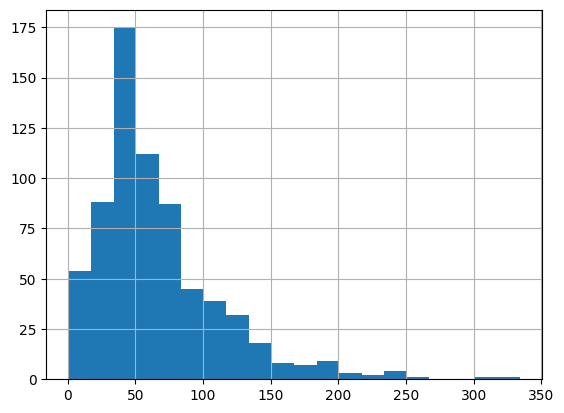

In [171]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~45458.44


<Axes: >

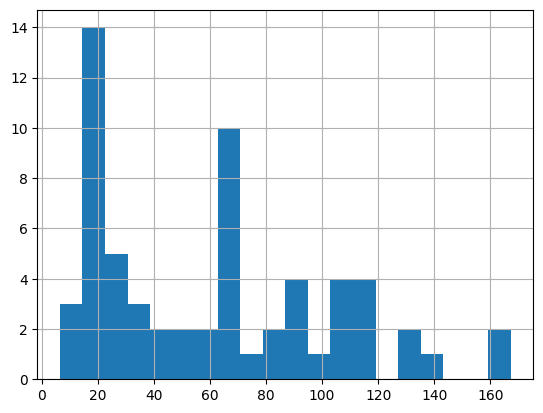

In [172]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [173]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [174]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [175]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [176]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [177]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [178]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [179]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [180]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 686
Total card age: 45458.44


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
103,Vocab,"Something Rotten, Fforde\nTannoy\nnoun | TAN-o...",c71f8bca99564b5b38f4a48ea260c697,-157.231553,52.62102,157.231553,-4051.818553,0.661571,0,0
106,Vocab,"Well of Lost Plots, Fforde\nPanjandrum\nnoun |...",93651b399223130fd91e2c9fd6d47ade,-123.594610,52.62102,157.231553,-4051.818553,0.661571,3,0
207,Vocab,Structured Credit Offers Different Risk Levels...,98239243e90fd6170d05acfddff1bf4b,-90.064722,52.62102,157.231553,-4051.818553,0.661571,6,0
297,Vocab,Lost in a Good Book\nAntimacassar: A small clo...,42bbbde6235b3db6867460f2491aaeb1,-76.544488,52.62102,157.231553,-4051.818553,0.661571,9,0
300,Vocab,"Red Side Story, FForde\nTurpitude\nPronunciati...",3e9a893c10b5915e095a45929fbd6a06,-71.600296,52.62102,157.231553,-4051.818553,0.661571,12,0
301,Vocab,"Something Rotten, Fforde\nPaella\nnoun | pah-A...",a37b3188a1d9c867d96671c96fbb61bf,-63.754093,52.62102,157.231553,-4051.818553,0.661571,15,0
384,Vocab,"Well of Lost Plots, Fforde\nInsouciance\nnoun ...",ae15401d43ed91aa235054578c87ffd1,-61.740518,52.62102,157.231553,-4051.818553,0.661571,18,0
456,Vocab,"Something Rotten, Fforde\nThylacine\nnoun | TH...",755d01fe4fbce3e79bc958b29f734803,-58.496850,52.62102,157.231553,-4051.818553,0.661571,21,0
459,Vocab,"Something Rotten, Fforde\nMuslin (curtains)\nn...",eb83088ac84321e16f95b700f58e4cf6,-55.260575,52.62102,157.231553,-4051.818553,0.661571,24,0
518,Vocab,"Well of Lost Plots, Fforde\nFoolscap\nnoun | F...",7bc3a1b3cf6c60a4a387d6fb342d8781,-54.064947,52.62102,157.231553,-4051.818553,0.661571,27,0


## Age Mean

In [181]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [182]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [183]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [184]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [185]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
526,Azure VM + Developer,Dependency Management\nThe process of tracking...,774acfd871be251904fda0a918338ef6,-0.625492,3.59106,9.200064,-122.096039,0.713109,33,0
528,Azure VM + Developer,Language Server Protocol (LSP)\nA communicatio...,78474be23aee1e1a6f611ef57c633fc6,-0.682079,3.59106,9.200064,-122.096039,0.713109,32,2
418,Azure VM + Developer,Debug Adapter Protocol\nA VS Code protocol tha...,6a90ea3b3e03a7a341e1227b67bf7f7d,-0.831927,3.59106,9.200064,-122.096039,0.713109,31,1
417,Azure VM + Developer,Dotfiles\nA collection of personal configurati...,bc791352f938ed873353ee48a848a43e,-0.945605,3.59106,9.200064,-122.096039,0.713109,30,0
341,Azure VM + Developer,Azure Policy\nA governance tool that defines a...,c2962cf6d9fb6d8aa1d619fc6fe36ff6,-1.470999,3.59106,9.200064,-122.096039,0.713109,29,2
342,Azure VM + Developer,.ssh/known_hosts\nA file used by SSH to store ...,d4f9279a08485d568b293f2c2f417297,-1.560757,3.59106,9.200064,-122.096039,0.713109,28,1
527,Azure VM + Developer,Remote Development\nA workflow where the code ...,8768fbbd3be8e62c25be8705689bbc02,-1.569123,3.59106,9.200064,-122.096039,0.713109,27,0
416,Azure VM + Developer,Formatter\nA tool that automatically reformats...,47198cd854975ce6917760d7fc32f108,-1.581156,3.59106,9.200064,-122.096039,0.713109,26,2
344,Azure VM + Developer,VS Code Workspace (.code-workspace)\nA VS Code...,d6d9a8f902e28c32abb08aeabaa29c4f,-1.688756,3.59106,9.200064,-122.096039,0.713109,25,1
477,Azure VM + Developer,Test Pyramid\nA testing strategy that favors m...,304a7c285662cd3d8acb09c2b8774c30,-1.766970,3.59106,9.200064,-122.096039,0.713109,24,0


In [186]:
existing_cards.head(10).sum()

head                   VocabVocabVocabVocabVocabVocabVocabVocabVocabV...
body                   Something Rotten, Fforde\nTannoy\nnoun | TAN-o...
hash                   c71f8bca99564b5b38f4a48ea260c69793651b39922313...
age                                                          -812.352652
subject_mean_age                                              526.210202
subject_highest_age                                          1572.315525
subject_age_sum                                            -40518.185533
head_random_roll                                                6.615711
count                                                                135
n_fold                                                                 0
dtype: object

In [187]:
existing_cards['age'].mean()

-66.26595220461596